# Aplicando lógica borrosa a batallas de ejércitos

Imagina un caluroso día de verano, tumbado, tranquilo, mirando al techo sin hacer nada

**Y de repente**, llega un momento que te levantas a por un helado

- Quizá hacía _"bastante calor"_, o tenías _"un poco de antojo"_, o simplemente estabas _"algo aburrido"_
- Los términos _"calor"_, _"antojo"_ o _"aburrimiento"_ no son absolutas
  - Cada una está en un rango de valores
  - Esto también incluye el resultado de la decisión
    - Puede ser desde "comer algo de helado" a "ponerse ciego de helado"
    - Dependerá además de las variables de entrada; no es lo mismo _"un poco de antojo"_ que _"mucho antojo"_

Claro, esto en nuestro software no lo solemos programar así

- Primero, solemos usar valores booleanos de tipo `hot`, `craving` o `bored`
- Segundo, solemos formar las reglas de la forma

```python
if hot and craving and bored:
    fulano.get_ice_cream()
```

Lo malo es que este tipo de códigos es muy "antinatural"

- El comprtamiento de los agentes que lo usen no será fluido

Si queremos hacerlo más complejo, la solución pasa por añadir más condiciones

- Y condiciones a esas condiciones
  - Con más condiciones dentro de esas condiciones
- Vamos, un código más complejo

**La lógica borrosa nos puede ayudar a generar comportamiento más fluidos en determinados casos**

Vamos a ver cómo funciona en un caso práctico

## Lógica borrosa en el comporamiento de batallones

Supongamos que tenemos un juego de batallas, estilo Total War

Queremos programar el comportamiento de alto nivel de la IA de los enemigos

- Queremos que, en función de las variables `tamaño`, `moral`, `ataque` y `defensa`, decida si `huir`, `mantener_posición` o `atacar`
  - **Tamaño**: Mide la diferencia entre el número de unidades aliadas frente enemigas (máx. 100 uds por batallón)
  - **Moral**: La moral actual del ejército, de 0 (fatal) a 100 (subidón)
  - **Fuerza**: De 1 (triste) a 100 (Dr. Manhattan)
  - **Defensa**: De 1 (muñón) a 100 (Niku)
  - **Acción**: de -1 (huir) a +1 (atacar)

Vamos a usar la librería [skfuzzy](https://scikit-fuzzy.github.io/scikit-fuzzy/) para crear un controlador para esta IA

Comenzaremos por importar las librerías que usaremos a lo largo de la presentación

In [43]:
from ipywidgets import interactive, widgets
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
from skfuzzy.control.visualization import FuzzyVariableVisualizer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Procedimiento general

El esquema general de un controlador borroso es el siguiente

![Esquema de controlador borroso](fuzzy-controller.png "Esquema de controlador borroso")

Por tanto, en cada instante de tiempo vamos a realizar el siguiente proceso:

1. Introducir las variables de entrada en el controlador y convertirlas en valores borrosos
2. Realizar la inferencia borrosa
3. Defuzzificar para obtener un valor exacto de nuestra variable de salida

Vamos descomponer nuestro controlador en estos tres pasos

### Fuzzificación

En esta fase tomaremos los valores de entrada y los convertiremos en valores borrosos

- Se definen a través de las funciones de pertenencia (indican el grado de pertenencia de un valor al conjunto borroso que caracterizan)

In [46]:
size = ctrl.Antecedent(np.arange(-100, 100, 1), 'size')
morale = ctrl.Antecedent(np.arange(0, 100, 1), 'morale')
attack = ctrl.Antecedent(np.arange(0, 100, 1), 'attack')
defense = ctrl.Antecedent(np.arange(0, 100, 1), 'defense')
fatigue = ctrl.Antecedent(np.arange(0, 100, 1), 'fatigue')
flee_prob = ctrl.Consequent(np.arange(0, 1, 0.01), 'flee_prob')

names = 'low', 'average', 'high'
size.automf(names=names)
morale.automf(names=[names[0], names[-1]])
attack.automf(names=names)
defense.automf(names=names)
fatigue.automf(names=names)
flee_prob['low'] = fuzz.trapmf(flee_prob.universe, [0, 0, 0.35, 0.65])
flee_prob['high'] = fuzz.trapmf(flee_prob.universe, [0.35, 0.65, 1, 1])

Podríamos crear cada una de las variables de pertenencia como, por ejemplo:

```python
size['low'] = fuzz.trimf(size.universe, [-100, -100, 0])
size['average'] = fuzz.trimf(size.universe, [-100, 0, 100])
size['high'] = fuzz.trimf(size.universe, [0, 100, 100])
```

Pero para mayor sencillez los hemos calculado automáticamente

Veamos qué forma tiene, por ejemplo, `size`:

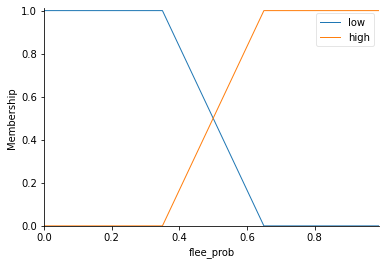

In [48]:
a = flee_prob.view()

### Inferencia

El bloque de inferencia se nutre de las reglas lógicas y el proceso de inferencia

- Lo bueno es que la librería ya nos implementa todo el proceso de inferencia
  - Y además define valores por defecto así que, en un principio, no nos tenemos que preocupar más que de las reglas
- Sólo nos tenemos que preocupar de las reglas y de la sintáxis (`|` para "o", `&` para "y", y `~` para "no")

In [49]:
rules = [
    ctrl.Rule(size['low'], flee_prob['high']),
    ctrl.Rule(~size['low'], flee_prob['low']),
    ctrl.Rule(morale['low'], flee_prob['high']),
    ctrl.Rule(morale['low'] & fatigue['average'], flee_prob['high']),
    ctrl.Rule(morale['high'] & fatigue['average'], flee_prob['low']),
    ctrl.Rule(morale['high'], flee_prob['low']),
    ctrl.Rule(attack['high'], flee_prob['low']),
    ctrl.Rule(defense['high'], flee_prob['low']),
    ctrl.Rule(fatigue['low'], flee_prob['low']),
    ctrl.Rule(fatigue['high'], flee_prob['high']),
    ctrl.Rule(attack['average'] & defense['average'], flee_prob['low']),
    ctrl.Rule(attack['low'] | defense['low'], flee_prob['high']),
]

Y ya está, la verdad es que definir las reglas no es difícil
- Lo difícil es hacerlo de manera que reflejen realmente el comportamiento que queremos

### Defuzzificación

En este punto, la salida del bloque de inferencia es una pertenencia a un conjunto borroso

Pero, ¿os acordáis cuando decíamos que el controlador incluía muchos comportamientos por defecto?

- Pues la defuzzificación es otro más de ellos
- Vamos, que no hace falta tocarlo a no ser que queramos un ajuste fino
  - Cosa que, ahora mismo, no queremos

## Nuestro controlador funcionando

Ahora, vamos a construir nuestro controlador, que es tansencillo como indicarle las reglas

- Como decíamos, mucho comportamiento está implementado por defecto
- En las reglas, además, está toda la información acerca de variables de entrada, de salida, de conjuntos borrosos, ...

In [50]:
batallion_ctrl = ctrl.ControlSystem(rules)

Y con nuestro controlador creado, vamos a simular valores de entrada para ver cómo se comportaría

In [51]:
batallion_sim = ctrl.ControlSystemSimulation(batallion_ctrl)

Estupendo; veamos cómo se comporta para un valor concreto de entradas y salidas

In [52]:
batallion_sim.input['size'] = 100
batallion_sim.input['morale'] = 90
batallion_sim.input['attack'] = 100
batallion_sim.input['defense'] = 9
batallion_sim.input['fatigue'] = 0
batallion_sim.compute()
print(f"Flee probability: {batallion_sim.output['flee_prob']}")

Flee probability: 0.4700721887359


Veamos cómo han sido las activaciones para estas reglas

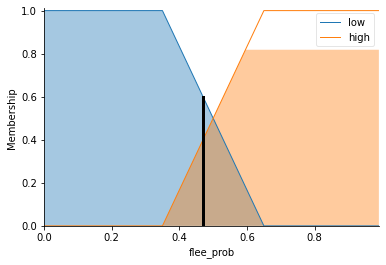

In [53]:
flee_prob.view(sim=batallion_sim)

<IPython.core.display.Javascript object>


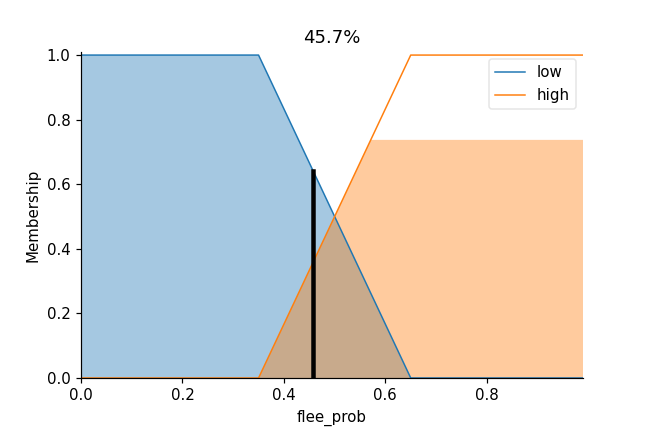

interactive(children=(IntSlider(value=0, description='size', min=-100), IntSlider(value=50, description='moral…

In [54]:
%matplotlib notebook
def f():
    simulator = ctrl.ControlSystemSimulation(batallion_ctrl)
    visualizer = FuzzyVariableVisualizer(flee_prob)
    fig, ax = visualizer.view(sim=simulator)
    
    def f(size, morale, attack, defense, fatigue):
        nonlocal fig
        nonlocal ax
        simulator.inputs({'size': size, 'morale': morale, 'attack': attack, 'defense': defense, 'fatigue': fatigue})
        simulator.compute()
        ax.clear()
        fig, ax = visualizer.view(sim=simulator)
        ax.set_title(f"{simulator.output['flee_prob']*100:.03}%")
        fig.canvas.draw()
    return f

size_slider = widgets.IntSlider(min=-100, max=100, step=1, value=0)
morale_slider = widgets.IntSlider(min=0, max=100, step=1, value=50)
attack_slider = widgets.IntSlider(min=0, max=100, step=1, value=50)
defense_slider = widgets.IntSlider(min=0, max=100, step=1, value=50)
fatigue_slider = widgets.IntSlider(min=0, max=100, step=1, value=50)
interactive(f(), size=size_slider, morale=morale_slider, attack=attack_slider, defense=defense_slider, fatigue=fatigue_slider)

## Conclusiones

Si obviamos todas las transparencias, texto, explicaciones y demás...

- **Hemos programado un controlador borroso en prácticamente 20 líneas de código**
- Además, con un comportamiento fluido y comprensible
  - Aunque no esté fino del todo, está expresado en sólo 8 reglas (líneas de código)

Por tanto, es una herramienta potente, sencilla y útil

- ¡Así que ya no tenéis excusa para no usar controladores borrosos!

# ¡Gracias!